In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import tables as tb
import tensorflow as tf

from sklearn.neighbors import KernelDensity

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import DBSCAN
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                            classification_report, accuracy_score,
                            precision_recall_curve)

from invisible_cities.reco.paolina_functions import voxelize_hits, make_track_graphs, find_extrema, blob_energies_hits_and_centres
from invisible_cities.evm.event_model import BHit

from tqdm import tqdm
from tensorflow import keras


from invisible_cities.reco.xy_algorithms  import barycenter

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import gaussian_filter, maximum_filter

sys.path.append('/scratch/pablovzqz/')

2025-11-26 15:56:07.119005: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 15:56:07.132415: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-26 15:56:07.255708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-26 15:56:07.257127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 15:56:08.604361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Data Loading

We load data here which has not gone though any clustering algorithm! We need to pass the clusterize hits function done by Samuele and get the actual SEP and PP signal

In [3]:
data_signal = pd.read_hdf('/data/pablovzqz/NEXT100-data/HE/data_sep.h5', key = 'sep')
data_bkg    = pd.read_hdf( '/data/pablovzqz/NEXT100-data/HE/data_pp.h5', key = 'pp' )

In [4]:
def clusterize_hits(df_pe_peak: pd.DataFrame, eps=2.3, npt=5)-> pd.DataFrame:

    """
    Cluster hits in 3D space for each event using DBSCAN.
    
    The coordinates are scaled to account for detector geometry differences 
    in samplig 
    
    Parameters
    ----------
    df_pe_peak : pd.DataFrame
    DataFrame containing hit information with columns 'X', 'Y', 'Z', and 'event'.
    
    Returns
    -------
    pd.DataFrame
    Modified DataFrame with an added 'cluster' column indicating the cluster label 
    for each hit (-1 for noise).
    """
    
    a = 14.55  # XY scale
    b = 3.7  # Z scale

    # Pre-allocate array for cluster labels
    cluster_labels = np.full(len(df_pe_peak), -9999, dtype=int)

    # Get values once (faster than repeatedly accessing DataFrame columns)
    coords = df_pe_peak[['X', 'Y', 'Z']].to_numpy()
    events = df_pe_peak['event'].to_numpy()
    
    # Use np.unique to get sorted event IDs
    unique_events = np.unique(events)
    
    for event_id in unique_events:
        mask = (events == event_id)
        X = coords[mask].copy()
        
        # Scale
        X[:, :2] /= a
        X[:, 2] /= b
        
        labels = DBSCAN(eps=eps, min_samples=npt).fit_predict(X)
        cluster_labels[mask] = labels

    df_pe_peak['cluster'] = cluster_labels

    return df_pe_peak

In [5]:
signal = clusterize_hits(data_signal)
bkg    = clusterize_hits(data_bkg)

In [6]:
signal['Q_by_cluster'] = signal.groupby(['event', 'cluster'])['Q'].transform('sum')
bkg['Q_by_cluster']    = bkg.groupby(   ['event', 'cluster'])['Q'].transform('sum')

max_Q_signal = signal.groupby('event')['Q_by_cluster'].transform('max')
max_Q_bkg    = bkg.groupby('event')['Q_by_cluster'].transform('max')

signal = signal[signal['Q_by_cluster'] == max_Q_signal]
bkg    = bkg[bkg['Q_by_cluster'] == max_Q_bkg]

Plot of a SEP event to check that our function did what it should

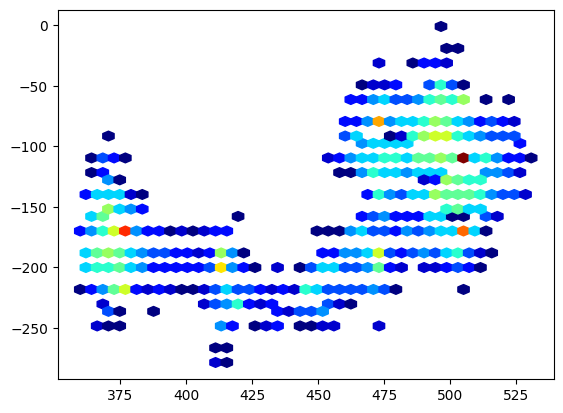

In [7]:
plt.hexbin(signal[signal.event == 439525].Z, signal[signal.event == 439525].Y, gridsize=40, cmap='jet', mincnt = 1);

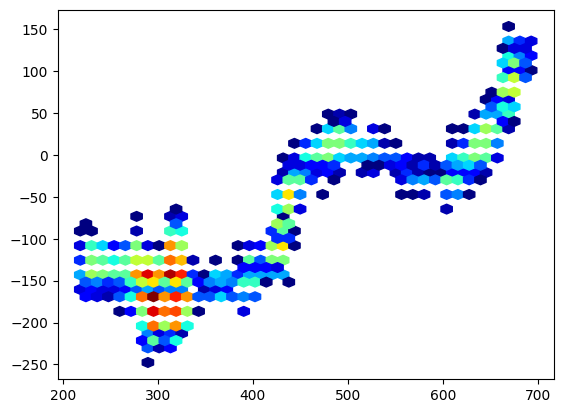

In [8]:
plt.hexbin(bkg[bkg.event == 236797].Z, bkg[bkg.event == 236797].Y, gridsize=40, cmap='jet', mincnt = 1);

In [10]:
bkg.to_csv('/home/pablovzqz/background_clean.csv')

In [9]:
event_number = bkg.event.unique()[1]
event_bkg_0 = bkg[bkg.event == event_number]

# KDE en 2D (Z, Y)

Probamos encontrar los blobs en 2 dimensiones y tratamos después de generalizarlo al caso tridimensional. La idea debería ser similar.

In [10]:
Z = event_bkg_0['Z'].to_numpy()
Y = event_bkg_0['Y'].to_numpy()

positions = event_bkg_0[['Z', 'Y']].to_numpy()  # Nx2

N = positions.shape[0]
d = positions.shape[1]  

sigma = np.std(positions, axis=0).mean()
h_scott = sigma * N ** (-1./(d+4))

D = 0.17
t_eff = np.mean(event_bkg_0.Z.to_numpy()/0.865)
bandwidth = np.sqrt(h_scott**2 - 2*D*t_eff)

In [11]:
kde = KernelDensity(bandwidth = bandwidth, kernel = 'gaussian')
kde.fit(positions)

density = np.exp(kde.score_samples(positions))

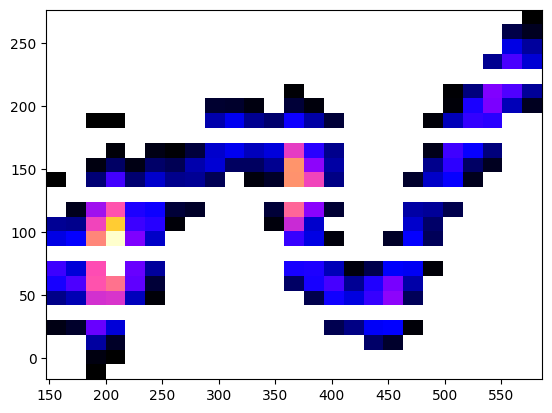

In [12]:
plt.hist2d(Z, Y, bins = (25, 25), weights=density, cmap='gnuplot2', cmin = 1e-7);

Integral discreta total: 0.9613


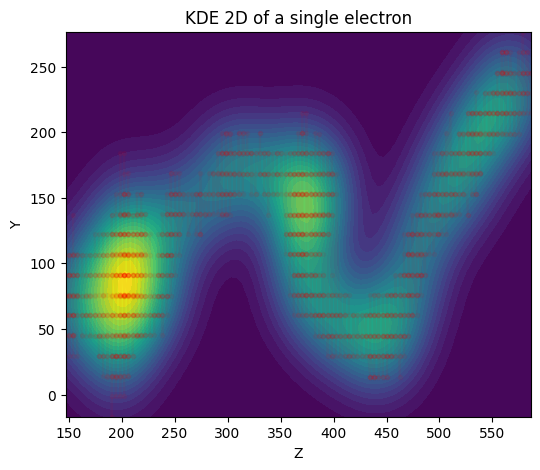

In [13]:
z = np.linspace(event_bkg_0.Z.min(), event_bkg_0.Z.max(), 80)
y = np.linspace(event_bkg_0.Y.min(), event_bkg_0.Y.max(), 80)
Z, Y = np.meshgrid(z, y)
grid = np.vstack([Z.ravel(), Y.ravel()]).T

log_density = kde.score_samples(grid)
density = np.exp(log_density).reshape(Z.shape)

dy = y[1]-y[0]
dz = z[1]-z[0]

total_prob = np.sum(density) * dz * dy
print(f"Integral discreta total: {total_prob:.4f}")

density_rebinned = density * dz * dy

plt.figure(figsize=(6,5), facecolor='white')
plt.contourf(Z, Y, density_rebinned, levels=30, cmap='viridis', vmin = 1e-7)
plt.plot(event_bkg_0.Z, event_bkg_0.Y, alpha = 0.05,  marker =  '.', color = 'red')
plt.xlabel('Z')
plt.ylabel('Y')
plt.title('KDE 2D of a single electron')
# plt.colorbar(label='Density')
plt.show()

In [14]:
signal_event_number = signal.event.unique()[5]
signal_event = signal[signal.event == signal_event_number]

In [15]:
Z = signal_event['Z'].to_numpy()
Y = signal_event['Y'].to_numpy()

positions = signal_event[['Z', 'Y']].to_numpy()  # Nx2

N = positions.shape[0]
d = positions.shape[1]  

sigma = np.std(positions, axis=0).mean()
h_scott = sigma * N ** (-1./(d+4))

D = 0.17
t_eff = np.mean(signal_event.Z.to_numpy()/0.865)
# bandwidth = np.sqrt(h_scott**2 - 2*D*t_eff)

In [16]:
kde = KernelDensity(bandwidth = 5, kernel = 'gaussian')
kde.fit(positions, sample_weight = signal_event.E.to_numpy())

density = np.exp(kde.score_samples(positions))

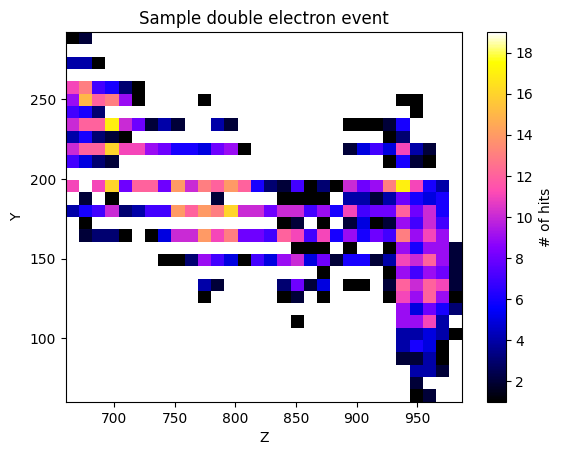

In [17]:
plt.hist2d(Z, Y, bins = (30, 30), cmap='gnuplot2', cmin = 1);
plt.xlabel("Z");
plt.ylabel("Y");
plt.title("Sample double electron event");
plt.colorbar(label='# of hits');

Integral discreta total: 0.9967


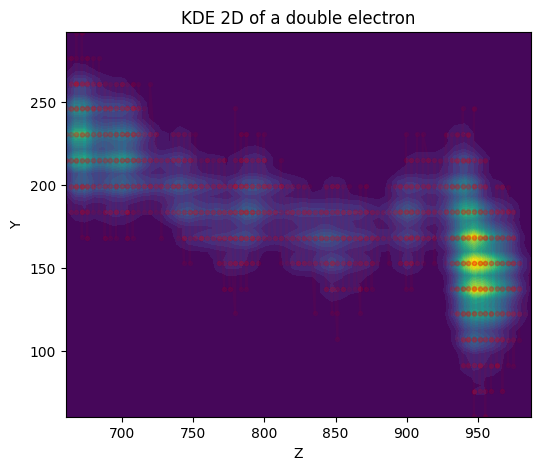

In [18]:
z = np.linspace(signal_event.Z.min(), signal_event.Z.max(), 50)
y = np.linspace(signal_event.Y.min(), signal_event.Y.max(), 50)
Z, Y = np.meshgrid(z, y)
grid = np.vstack([Z.ravel(), Y.ravel()]).T

log_density = kde.score_samples(grid)
density = np.exp(log_density).reshape(Z.shape)

dy = y[1]-y[0]
dz = z[1]-z[0]

total_prob = np.sum(density) * dz * dy
print(f"Integral discreta total: {total_prob:.4f}")

density_rebinned = density * dz * dy

plt.figure(figsize=(6,5), facecolor='white')
plt.contourf(Z, Y, density_rebinned, levels=30, cmap='viridis' )
plt.plot(signal_event.Z, signal_event.Y, alpha = 0.05,  marker =  '.', color = 'red')
plt.xlabel('Z')
plt.ylabel('Y')
plt.title('KDE 2D of a double electron')
# plt.colorbar(label='Densidad')
plt.show()

In [19]:
def kde_ridge_statistical(positions, energies, bins=60, bandwidth=None, smooth_sigma=2, axis_z=0, axis_y=1, max_jump=20):
    """
    Encuentra la cresta del KDE siguiendo el camino de máxima densidad
    con restricción de continuidad espacial.
    """
    positions = np.asarray(positions)
    z = positions[:, axis_z]
    y = positions[:, axis_y]
    
    data = np.vstack([z, y]).T
    n, d = data.shape

    # Computing bandwidth for each individual case
    if bandwidth is None:

        sigma = np.mean(np.std(data, axis=0))
        bandwidth = sigma * n ** (-1. / (d + 4))
    
    # Computes the KDE -> get the probability of finding an electron in that position.
    kde = KernelDensity(bandwidth = bandwidth, kernel='gaussian')
    kde.fit(data, sample_weight = energies)
    
    # Create z bins and centers for the search at each z position
    z_bins = np.linspace(z.min(), z.max(), bins + 1)
    z_centers = (z_bins[:-1] + z_bins[1:]) / 2
    
    # Same thing for Y
    y_min, y_max = y.min(), y.max()
    y_search = np.linspace(y_min, y_max, 200)
    
    y_ridge = []
    y_prev = None

    # Computes the maximum and penalizes disconnectivity
    
    for z_c in z_centers:
        grid_points = np.column_stack([np.full_like(y_search, z_c), y_search])
        densities = np.exp(kde.score_samples(grid_points))
        
        if y_prev is None:
            idx_max = np.argmax(densities)
        else:
            dist = np.abs(y_search - y_prev)
            weights = densities * np.exp(-dist**2 / (2 * max_jump**2))
            idx_max = np.argmax(weights)
        
        y_ridge.append(y_search[idx_max])
        y_prev = y_search[idx_max]
    
    # Suavizar
    y_ridge = gaussian_filter1d(y_ridge, sigma=smooth_sigma)
    
    return z_centers, y_ridge

In [20]:
def find_peaks_with_smoothing(positions, energies, bandwidth=None, 
                               grid_resolution=50,
                               smooth_sigma=1.5,
                               thr = 0.5):
    """
    Aplica smoothing gaussiano adicional antes de buscar picos.
    Útil si el KDE tiene mucho ruido.
    """        
    positions = np.asarray(positions)
    z, y = positions[:, 0], positions[:, 1]
    
    # KDE
    data = np.vstack([z, y]).T
    n, d = data.shape
    if bandwidth is None:
        sigma = np.mean(np.std(data, axis=0))
        bandwidth = sigma * n ** (-1. / (d + 4))
    
    kde = KernelDensity(bandwidth = bandwidth, kernel='gaussian')
    kde.fit(data, sample_weight= energies)
    
    z_grid = np.linspace(z.min(), z.max(), grid_resolution)
    y_grid = np.linspace(y.min(), y.max(), grid_resolution)

    Z, Y = np.meshgrid(z_grid, y_grid)
    grid_points = np.column_stack([Z.ravel(), Y.ravel()])
    
    densities = np.exp(kde.score_samples(grid_points))
    density_grid = densities.reshape(Z.shape)

    density_smooth = gaussian_filter(density_grid, sigma=smooth_sigma)
    
    local_max = maximum_filter(density_smooth, size=5) == density_smooth
    max_density = density_smooth.max()
    threshold = max_density * thr


    local_max = local_max & (density_smooth > threshold)
    
    # Extraer picos
    peaks_indices = np.argwhere(local_max)
    peaks = []
    
    for idx in peaks_indices:
        i, j = idx
        peaks.append({
            'z': Z[i, j],
            'y': Y[i, j],
            'density': density_smooth[i, j],
            'density_original': density_grid[i, j]
        })
    
    peaks = sorted(peaks, key=lambda x: x['density'], reverse=True)
    
    return peaks[:2], (Z, Y, density_grid, density_smooth)

In [21]:
def peak_finder_3D(positions, energies, bandwidth=None, grid_resolution=50, 
                   smooth_sigma=1.5, dimensions=3, thr = 0.5):
    """
    Aplica find_peaks_with_smoothing a múltiples proyecciones 2D.
    
    Parameters:
    -----------
    positions : array-like, shape (n_points, dimensions)
        Posiciones de los puntos. Primera columna es X (común),
        resto son Y, Z, etc.
    bandwidth : float, optional
        Ancho de banda para el KDE
    grid_resolution : int
        Resolución de la grilla
    smooth_sigma : float
        Sigma para el smoothing gaussiano
    dimensions : int
        Número de dimensiones (incluye X)
        
    Returns:
    --------
    all_peaks : dict
        Diccionario con picos para cada proyección
    """
    positions = np.asarray(positions)
    peak_pos = []
    
    all_peaks = {}
    projection_names = ['X', 'Y']  # Nombres para dimensiones adicionales
    
    for i in range(dimensions - 1):
        # Crear array 2D con X (columna 0) y la dimensión actual
        positions_2d = positions[:, [0, i + 1]]  # Selecciona X y la i-ésima dimensión
        
        projection_name = f'Z{projection_names[i]}'
        
        print(f"Buscando picos en proyección {projection_name}...")
        
        # Llamar a tu función existente sin modificarla
        peaks,  (Z, Y, density_grid, density_smooth) = find_peaks_with_smoothing(
            positions_2d, energies,
            bandwidth=bandwidth,
            grid_resolution=grid_resolution,
            smooth_sigma=smooth_sigma,
            thr = thr
        )
        
        # Ordenar picos por la coordenada Z (de menor a mayor)
        if peaks is not None and len(peaks) > 0:
            peaks = sorted(peaks, key=lambda p: p['z'])
        
        peak_pos.append(peaks)
        all_peaks[projection_name] = peaks
        
        if peaks is not None:
            print(f"  → Encontrados {len(peaks)} picos en {projection_name}")
        else:
            print(f"  → No se encontraron picos en {projection_name}")
    
    return all_peaks, peak_pos

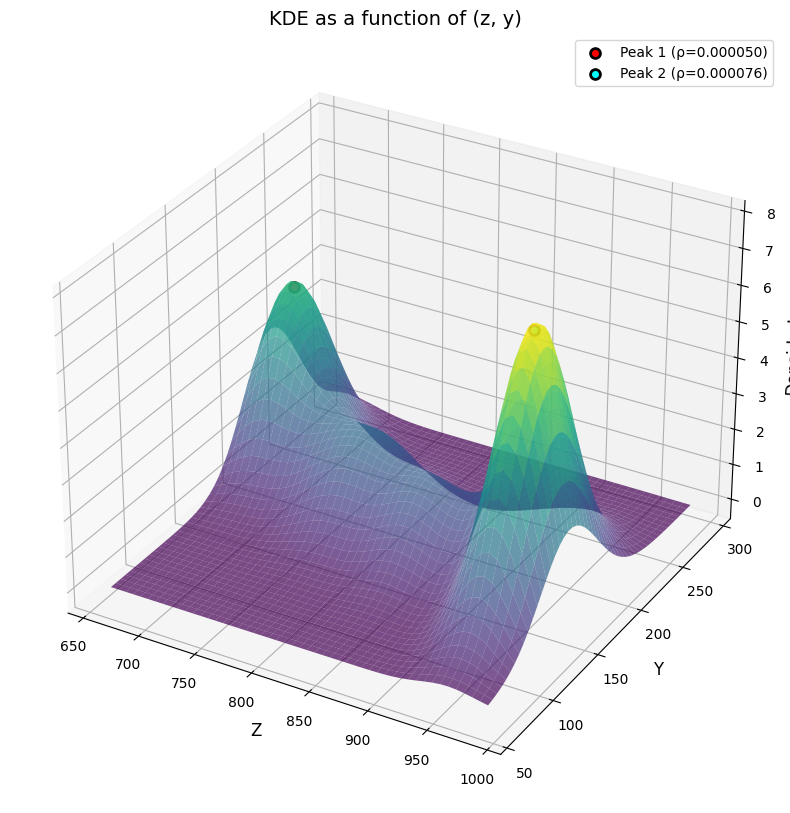


Pico 1:
  Z = 686.52
  Y = 221.85
  Density = 0.00005004

Pico 2:
  Z = 950.94
  Y = 151.62
  Density = 0.00007585


In [22]:
def visualize_peaks_3d(positions, energies, bandwidth=None):
    """
    Visualización 3D con los picos detectados.
    """
    peaks, (Z, Y, density_grid, density_smooth) = find_peaks_with_smoothing(positions, energies, bandwidth, grid_resolution = 100)
    density_grid = density_smooth
    
    # Ordenar picos por Z (de menor a mayor)
    peaks = sorted(peaks, key=lambda p: p['z'])
    
    z, y = positions[:, 0], positions[:, 1]
    data = np.vstack([z, y]).T
    n, d = data.shape
    
    if bandwidth is None:
        sigma = np.mean(np.std(data, axis=0))
        bandwidth = sigma * n ** (-1. / (d + 4))
    
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(data, sample_weight=energies)
    
    z_grid = np.linspace(z.min(), z.max(), 50)
    y_grid = np.linspace(y.min(), y.max(), 50)
    Z, Y = np.meshgrid(z_grid, y_grid)
    grid_points = np.column_stack([Z.ravel(), Y.ravel()])
    
    densities = np.exp(kde.score_samples(grid_points))
    density_grid = densities.reshape(Z.shape)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.plot_surface(Z, Y, density_grid, cmap='viridis', 
                          alpha=0.7, edgecolor='none')
    
    # Marcar picos
    if peaks:
        for i, peak in enumerate(peaks[:2]):
            color = 'red' if i == 0 else 'cyan'
            ax.scatter([peak['z']], [peak['y']], [peak['density']], 
                      c=color, marker='o', s=50, edgecolors='black', 
                      linewidths=2, label=f"Peak {i+1} (ρ={peak['density']:.6f})", 
                      zorder=10)
    
    ax.set_xlabel('Z', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Densidad', fontsize=12)
    ax.set_title('KDE as a function of (z, y)', fontsize=14)
    ax.legend()
    # plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()
    
    for i, peak in enumerate(peaks[:2]):
        print(f"\nPico {i+1}:")
        print(f"  Z = {peak['z']:.2f}")
        print(f"  Y = {peak['y']:.2f}")
        print(f"  Density = {peak['density']:.8f}")
    
    return peaks

peaks = visualize_peaks_3d(positions, energies = signal_event.E.to_numpy(), bandwidth=None)



In [27]:
skeleton = kde_ridge_statistical(positions, energies = signal_event.Ec.to_numpy(), bins = 300, axis_z = 0, axis_y = 1)

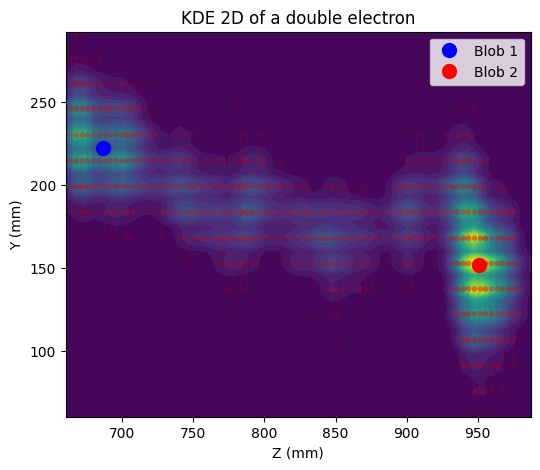

In [26]:
plt.figure(figsize=(6,5), facecolor='white')
plt.contourf(Z, Y, density_rebinned, levels=30, cmap='viridis')
plt.plot(signal_event.Z, signal_event.Y, alpha = 0.05,  marker =  '.', color = 'red')
# plt.plot(skeleton[0], skeleton[1], 'b--', linewidth=2)
plt.plot(peaks[0]['z'], peaks[0]['y'], 'bo', markersize=10, label='Blob 1')
plt.plot(peaks[1]['z'], peaks[1]['y'], 'ro', markersize=10, label='Blob 2')
plt.legend()

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.title('KDE 2D of a double electron')
# plt.colorbar(label='Densidad')
plt.show()

# Buscar picos en 3D

In [29]:
positions = signal_event[['Z', 'X', 'Y']].to_numpy()  # Nx3

N = positions.shape[0]
d = positions.shape[1]  

sigma = np.std(positions, axis=0).mean()
h_scott = sigma * N ** (-1./(d+4))

D = 0.17
t_eff = np.mean(signal_event.Z.to_numpy()/0.865)

In [30]:
kde = KernelDensity(bandwidth = 5, kernel = 'gaussian')
kde.fit(positions, )

density = np.exp(kde.score_samples(positions))

In [31]:
data, peaks = peak_finder_3D(positions, signal_event.E.to_numpy())

Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY


In [32]:
z1_1 = peaks[0][0]['z']
y1 = peaks[0][0]['y']

z2_1 = peaks[0][1]['z']
y2 = peaks[0][1]['y']

In [33]:
z1_2 = peaks[1][0]['z']
x1 = peaks[1][0]['y']

z2_2 = peaks[1][1]['z']
x2 = peaks[1][1]['y']

z1 = (z1_1 + z1_2)/2
z2 = (z2_1 + z2_2)/2

In [34]:
import plotly.graph_objects as go

# Tu gráfico base con KDE
fig = go.Figure(data=[go.Scatter3d(
    z=positions[:, 0],
    x=positions[:, 1],
    y=positions[:, 2],
    mode='markers',
    name='Hits',  # Nombre en la leyenda
    marker=dict(
        size=3,
        color=density,
        colorscale='Viridis',
        opacity=0.6,
        colorbar=dict(title="Densidad KDE"),
    ),
    text=[f'Densidad: {d:.2e}' for d in density],
    hovertemplate='Z: %{x:.2f}<br>X: %{y:.2f}<br>Y: %{z:.2f}<br>%{text}<extra></extra>'
)])

# Añadir puntos específicos (por ejemplo, picos)
puntos_z = [z1, z2]  # Coordenadas Z
puntos_x = [x1, x2]     # Coordenadas X
puntos_y = [y1, y2]     # Coordenadas Y

fig.add_trace(go.Scatter3d(
    x=puntos_y,
    y=puntos_x,
    z=puntos_z,
    mode='markers',
    name='Picos detectados',  # Nombre en la leyenda
    marker=dict(
        size=10,
        color='black',
        symbol='square',  # O 'diamond', 'cross', 'square'
        line=dict(color='darkred', width=2)
    ),
    text=[f'Pico {i+1}' for i in range(len(puntos_x))],
    hovertemplate='Pico<br>Z: %{x:.2f}<br>X: %{y:.2f}<br>Y: %{z:.2f}<extra></extra>'
))

fig.update_layout(
    title='KDE 3D con Picos',
    scene=dict(
        xaxis_title='X (cm)',
        yaxis_title='Y (cm)',
        zaxis_title='Z (cm)',
    ),
    width=900,
    height=700
)

fig.show()

# Try in different events 

In [ ]:
threshold = np.arange(0, 1, 0.1)
efficiencies_signals = np.array([0.0945945945945946, 0.0990990990990991, 0.0990990990990991, 0.12612612612612611, 0.15765765765765766, 0.21171171171171171, 0.36936936936936937, 0.5405405405405406, 0.7567567567567568, 0.9414414414414415])

In [ ]:
events_wrong_classified_per_threshold = []
events_of_signal = signal.event.unique()

threshold = np.arange(0, 1, 0.1)

for thr in threshold:

    events_wrong_classified = []

    for i, event_number in enumerate(events_of_signal):
        event = signal[signal.event == event_number]

        hits = event[['Z', 'Y', 'X']].to_numpy()  # Nx3

        kde = KernelDensity(bandwidth = 5, kernel = 'gaussian')
        kde.fit(hits, sample_weight = event.E.to_numpy())

        density = np.exp(kde.score_samples(hits))

        data, peaks = peak_finder_3D(hits, event.E.to_numpy(), thr = thr)

        if len(peaks[1])==2 and len(peaks[0]) == 2:

            z1_1 = peaks[0][0]['z']
            y1 = peaks[0][0]['y']

            z2_1 = peaks[0][1]['z']
            y2 = peaks[0][1]['y']

            z1_2 = peaks[1][0]['z']
            x1 = peaks[1][0]['y']

            z2_2 = peaks[1][1]['z']
            x2 = peaks[1][1]['y']

            z1 = (z1_1 + z1_2)/2
            z2 = (z2_1 + z2_2)/2

        else:
            print(f'Evento {i} con solo un pico')
            events_wrong_classified.append(event_number)
            continue

        if i%50 == 0:

            # z = np.linspace(event.Z.min(), event.Z.max(), 50)
            # y = np.linspace(event.Y.min(), event.Y.max(), 50)
            # Z, Y = np.meshgrid(z, y)
            # grid = np.vstack([Z.ravel(), Y.ravel()]).T

            # log_density = kde.score_samples(grid)
            # density = np.exp(log_density).reshape(Z.shape)

            # dy = y[1]-y[0]
            # dz = z[1]-z[0]

            # total_prob = np.sum(density) * dz * dy
            # print(f"Integral discreta total: {total_prob:.4f}")

            # density_rebinned = density * dz * dy

            # plt.figure(figsize=(6,5), facecolor='white')
            # plt.contourf(Z, Y, density_rebinned, levels=30, cmap='viridis' )
            # plt.plot(event.Z, event.Y, alpha = 0.05,  marker =  '.', color = 'red')
            # plt.xlabel('Z')
            # plt.ylabel('Y')
            # plt.title('KDE 2D of a double electron')
            # # plt.colorbar(label='Densidad')
            # plt.show()

            # p = visualize_peaks_3d(hits, energies = event.E.to_numpy(), bandwidth=None,)
            import plotly.graph_objects as go

            # Tu gráfico base con KDE
            fig = go.Figure(data=[go.Scatter3d(
                z=hits[:, 0],
                x=hits[:, 1],
                y=hits[:, 2],
                mode='markers',
                name='Hits',  # Nombre en la leyenda
                marker=dict(
                    size=3,
                    color=density,
                    colorscale='Viridis',
                    opacity=0.6,
                    colorbar=dict(title="Densidad KDE"),
                ),
                text=[f'Densidad: {d:.2e}' for d in density],
                hovertemplate='Z: %{x:.2f}<br>X: %{y:.2f}<br>Y: %{z:.2f}<br>%{text}<extra></extra>'
            )])

            # Añadir puntos específicos (por ejemplo, picos)
            puntos_z = [z1, z2]  # Coordenadas Z
            puntos_x = [x1, x2]     # Coordenadas X
            puntos_y = [y1, y2]     # Coordenadas Y

            fig.add_trace(go.Scatter3d(
                x=puntos_y,
                y=puntos_x,
                z=puntos_z,
                mode='markers',
                name='Picos detectados',  # Nombre en la leyenda
                marker=dict(
                    size=10,
                    color='black',
                    symbol='square',  # O 'diamond', 'cross', 'square'
                    line=dict(color='darkred', width=2)
                ),
                text=[f'Pico {i+1}' for i in range(len(puntos_x))],
                hovertemplate='Pico<br>Z: %{x:.2f}<br>X: %{y:.2f}<br>Y: %{z:.2f}<extra></extra>'
            ))

            fig.update_layout(
                title='KDE 3D con Picos',
                scene=dict(
                    xaxis_title='X (cm)',
                    yaxis_title='Y (cm)',
                    zaxis_title='Z (cm)',
                ),
                width=900,
                height=700
            )

            fig.show()
    events_wrong_classified_per_threshold.append(len(events_wrong_classified)/len(events_of_signal))


Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY


Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyecc

Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 1 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Evento 52 con solo un pico
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en Z

Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 1 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Evento 104 con solo un pico
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en 

Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 1 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Evento 155 con solo un pico
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 1 picos en ZY
Evento 156 con solo un pico
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...

Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 1 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 1 picos en ZY
Evento 203 con solo un pico
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en 

Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyecc

Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 1 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Evento 52 con solo un pico
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en ZX
Buscando picos en proyección ZY...
  → Encontrados 2 picos en ZY
Buscando picos en proyección ZX...
  → Encontrados 2 picos en Z

KeyboardInterrupt: 

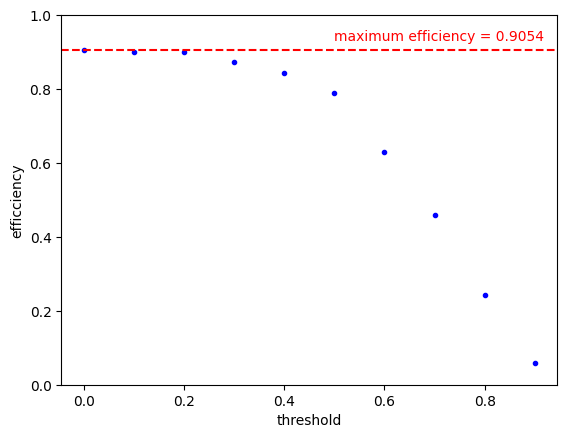

In [43]:
plt.plot(threshold, 1 - efficiencies_signals, '.', color = 'blue');
plt.xlabel("threshold");
plt.ylabel("efficciency");
plt.ylim(0,1);
plt.axhline(1 - efficiencies_signals[0], color = 'red', linestyle = '--');

plt.annotate(f'maximum efficiency = {np.round(1 - efficiencies_signals[0], 4)}', xy = (0.5, 0.93), color = 'red');

Conclusión: al bajar el corte a coger cualquier pico hay saturación; efecto de capacidad de resolución espacial del método?

# TOPOLOGY NEURAL NETWORK

In [11]:
def extract_topology_features(track_df):
    # --- PCA ---
    positions = track_df[['X', 'Y', 'Z']].to_numpy()
    energies = track_df['E'].to_numpy()

    centroid_geom = positions.mean(axis=0)
    centered = positions - centroid_geom
    cov_geom = np.cov(centered.T)
    vals, vecs = np.linalg.eigh(cov_geom)

    # Ordenar autovalores y autovectores de mayor a menor
    idx_sort = np.argsort(vals)[::-1]
    vals = vals[idx_sort]
    vecs = vecs[:, idx_sort]

    # --- Forma del track (ratios de eigenvalores) ---
    eigenvalue_ratio_23 = vals[2] / vals[0] if vals[0] > 0 else 0  # esfericidad
    eigenvalue_ratio_12 = vals[1] / vals[0] if vals[0] > 0 else 0  # planaridad

    # --- Proyecciones ---
    axis_long = vecs[:, 0]
    proj_long = centered @ axis_long
    order = np.argsort(proj_long)
    positions_ordered = positions[order]

    # --- Distancias ---
    track_length_path = np.sum(np.linalg.norm(np.diff(positions_ordered, axis=0), axis=1))
    track_length_straight = np.linalg.norm(positions_ordered[-1] - positions_ordered[0])

    # --- Distancias entre todos los hits ---
    pairwise_distances = pdist(positions)
    mean_distance = pairwise_distances.mean() / track_length_straight if track_length_straight > 0 else 0
    std_distance = pairwise_distances.std() / track_length_straight if track_length_straight > 0 else 0

    # --- Tortuosidad ---
    tortuosity = track_length_path / track_length_straight if track_length_straight > 0 else 0

    # --- Asimetría de carga ---
    if np.any(proj_long < 0) and np.any(proj_long > 0):
        A_charge_L = energies[proj_long > 0].sum() / energies[proj_long < 0].sum()
    else:
        A_charge_L = np.nan  # evita división por cero si todo está a un lado

    # --- Número de picos ---
    hist, edges = np.histogram(proj_long, bins=30, weights=energies / np.sum(energies))
    peaks, _ = find_peaks(hist, prominence=0.3 * hist.max())
    n_peaks = len(peaks)

    return {
        "eigenvalue_ratio_23": eigenvalue_ratio_23,
        "eigenvalue_ratio_12": eigenvalue_ratio_12,
        "mean_distance": mean_distance,
        "std_distance": std_distance,
        "tortuosity": tortuosity,
        "assymetry_L": A_charge_L,
        "n_peaks": n_peaks,
    }

In [12]:
signal_features = (
    signal
    .groupby('event')
    .apply(extract_topology_features)
    .apply(pd.Series)              # convierte cada dict en columnas
    .reset_index()                 # devuelve event y cluster como columnas normales
)

background_features = (
    bkg
    .groupby('event')
    .apply(extract_topology_features)
    .apply(pd.Series)              # convierte cada dict en columnas
    .reset_index()                 # devuelve event y cluster como columnas normales
)

signal_features['label'] = 1
background_features['label'] = 0
signal_features


,event,eigenvalue_ratio_23,eigenvalue_ratio_12,mean_distance,std_distance,tortuosity,assymetry_L,n_peaks,label
0,31162,0.171458,0.772654,0.364061,0.158337,359.510788,0.870622,1.0,1
1,61828,0.268313,0.376591,0.252169,0.113281,270.289026,1.162431,2.0,1
2,66402,0.132993,0.180413,0.374504,0.188569,288.156505,1.073955,2.0,1
3,80172,0.285624,0.339693,0.321974,0.142779,279.164249,0.945948,2.0,1
4,97910,0.199981,0.575670,0.323543,0.139736,115.730257,0.997168,5.0,1
...,...,...,...,...,...,...,...,...,...
217,3727332,0.169536,0.237661,0.379803,0.181451,242.128663,1.032194,2.0,1
218,3762068,0.116188,0.207788,0.373003,0.186221,220.589697,1.443940,3.0,1
219,3776060,0.074178,0.113049,0.422168,0.233345,226.170884,1.080615,2.0,1
220,3804568,0.140306,0.248726,0.363482,0.175856,189.163853,1.062180,2.0,1


In [15]:
background_features

,event,eigenvalue_ratio_23,eigenvalue_ratio_12,mean_distance,std_distance,tortuosity,assymetry_L,n_peaks,label
0,4162,0.256546,0.644447,0.367502,0.172489,628.680463,0.426465,1.0,0
1,7307,0.126489,0.173109,0.326393,0.168605,466.128070,1.308893,1.0,0
2,7988,0.121640,0.389336,0.419184,0.198276,562.237883,1.382091,2.0,0
3,8856,0.065991,0.277761,0.370526,0.195652,445.257414,1.225578,2.0,0
4,11809,0.044263,0.286468,0.446191,0.244632,275.245556,0.602884,2.0,0
...,...,...,...,...,...,...,...,...,...
1917,3835300,0.062094,0.386817,0.439838,0.217512,468.028041,0.973059,3.0,0
1918,3835800,0.121940,0.226451,0.411154,0.201956,470.826257,1.052767,2.0,0
1919,3836255,0.070508,0.308302,0.396778,0.203409,484.750540,1.510168,2.0,0
1920,3847250,0.123070,0.301965,0.386769,0.192208,444.544690,1.385907,1.0,0


In [16]:
features_complete = pd.concat([signal_features, background_features], ignore_index=True)
features_complete = features_complete.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
features_complete.to_csv('/home/pablovzqz/features_new.csv')

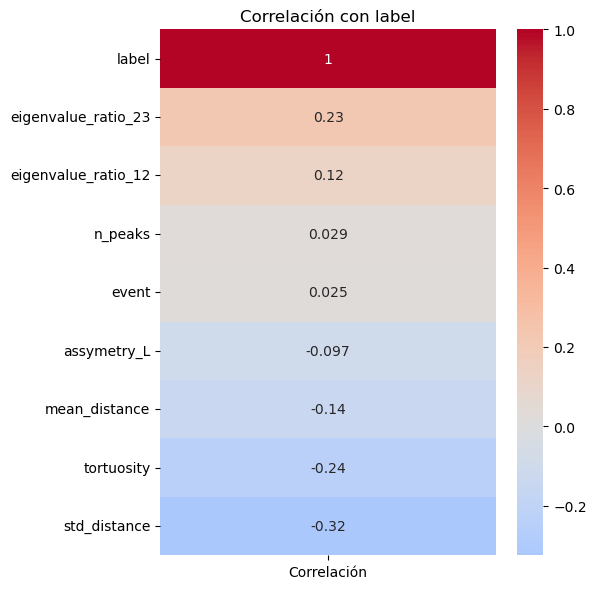

In [ ]:
target_col = 'label'

# Calcular correlaciones
corr_with_target = (
    features_complete
    .corrwith(features_complete[target_col], method='pearson')
    .sort_values(ascending=False)
    .to_frame(name='Correlación')  # aquí le damos nombre a la columna
)

# Plot vertical
plt.figure(figsize=(6, 6))
sns.heatmap(
    corr_with_target,
    annot=True,
    cmap='coolwarm',
    center=0,
    cbar=True
)

plt.title(f'Correlación con {target_col}', fontsize=12)
plt.xlabel('')  # quitamos texto extra

plt.tight_layout()
plt.show()



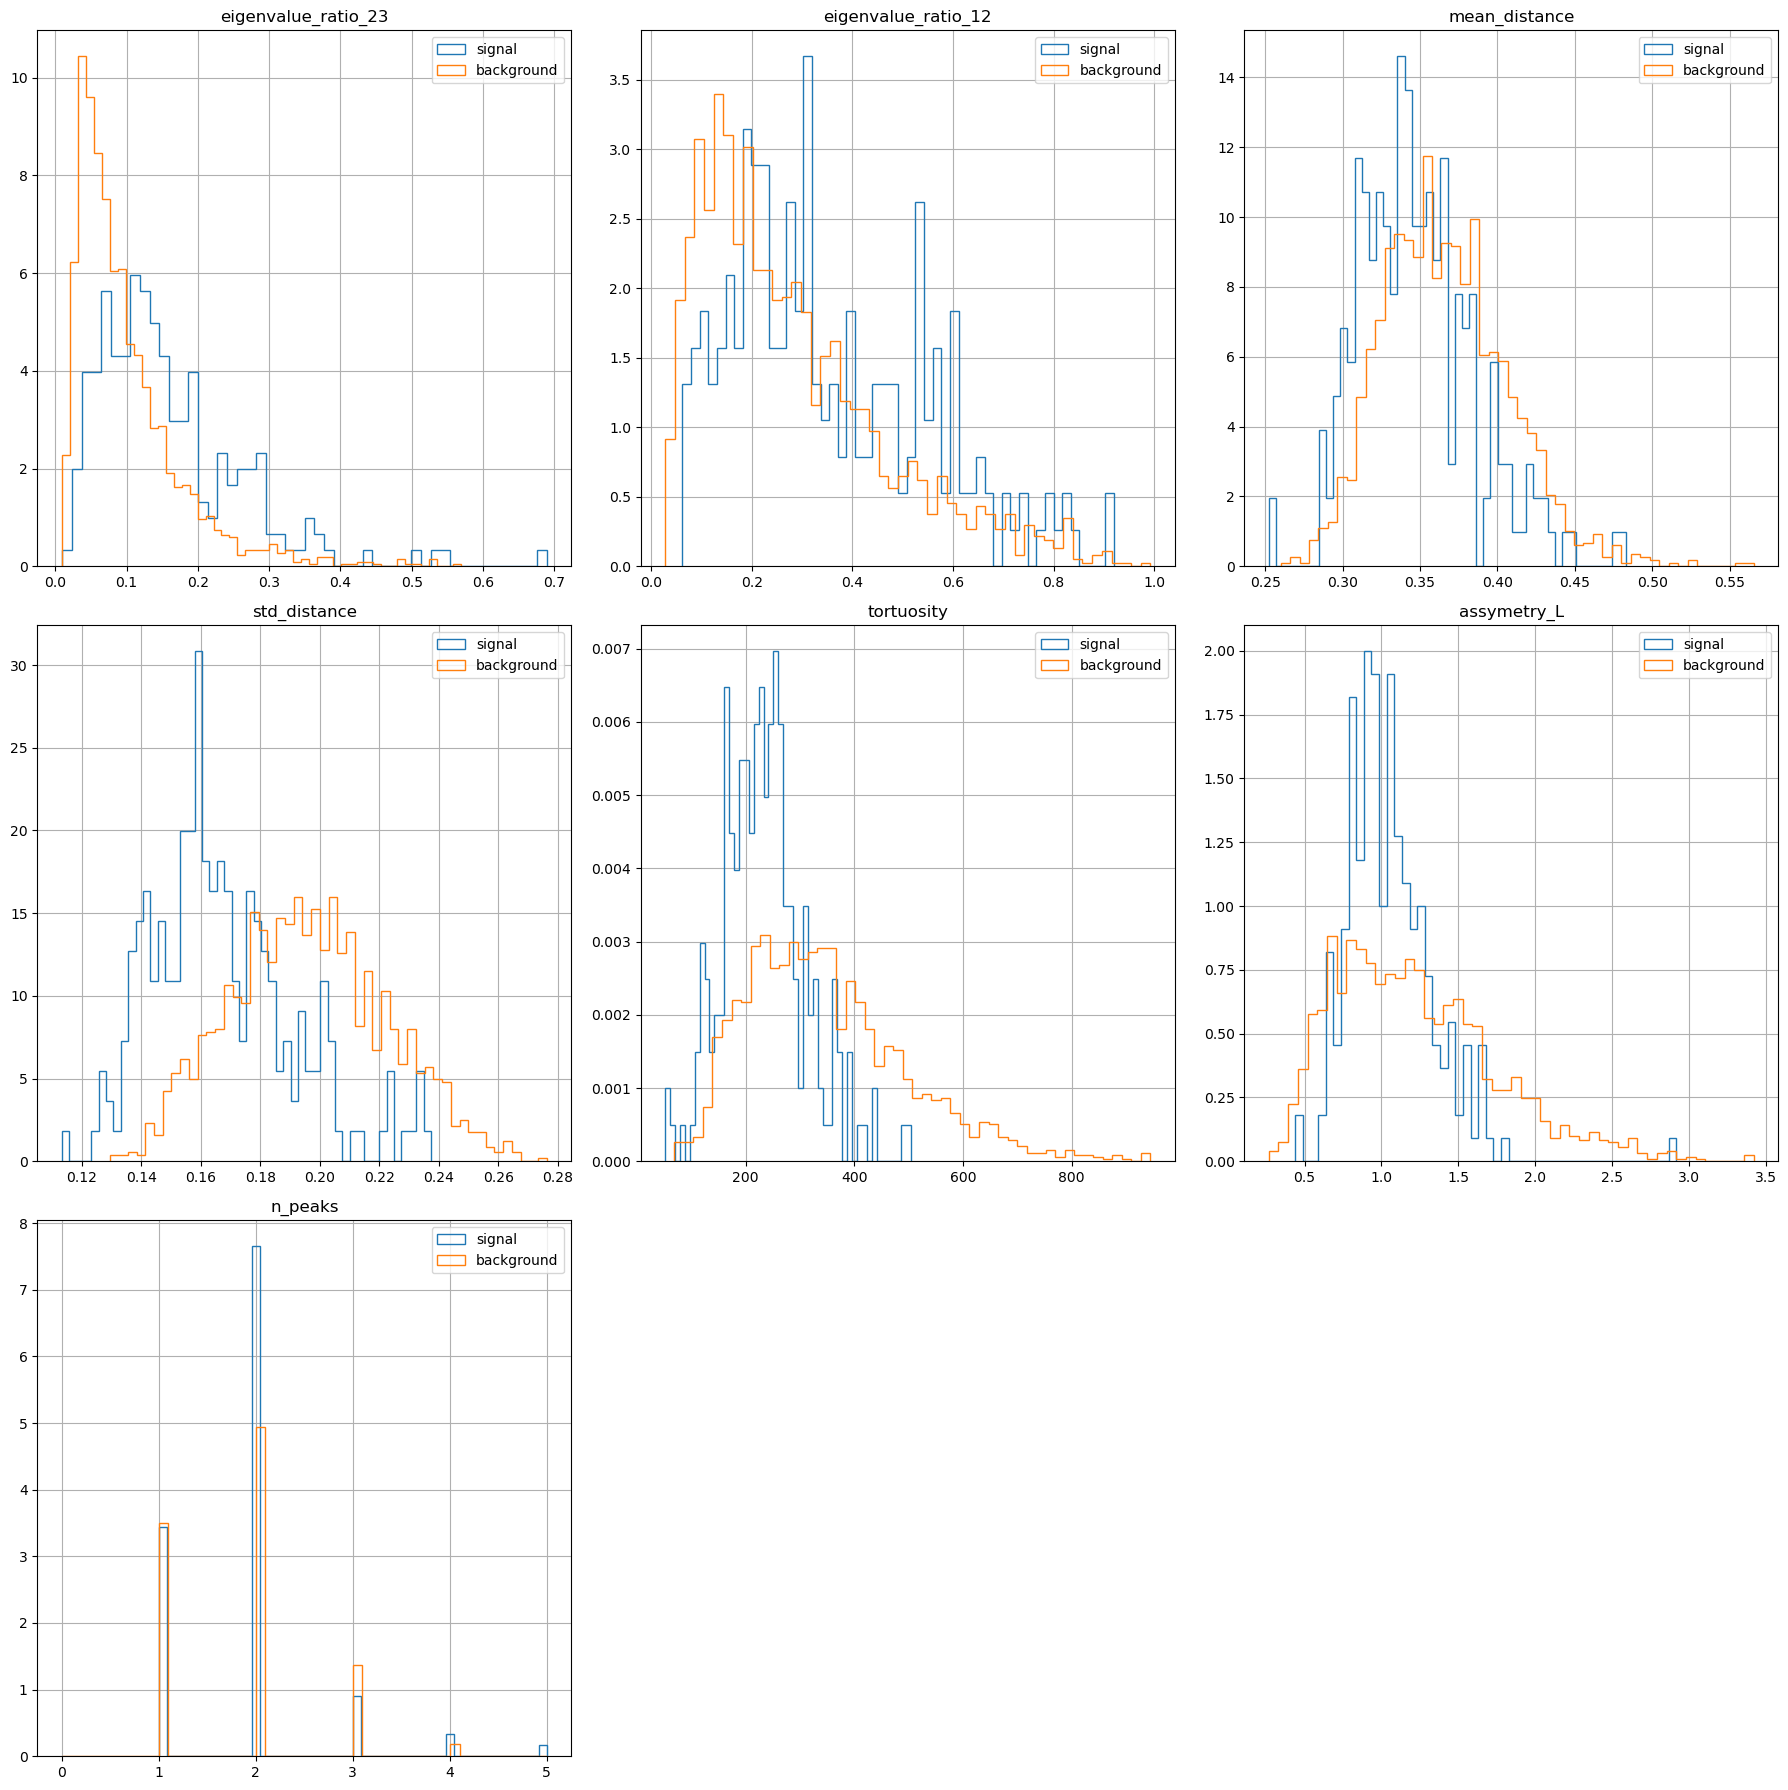

In [ ]:
signal_plot = signal_features.drop(columns=['event', 'label']).copy()
background_plot = background_features.drop(columns=['event', 'label']).copy()

fig, axs = plt.subplots(3, 3, figsize=(18, 18))
axs =axs.flatten()
for i, col in enumerate(signal_plot.columns):
    axs[i].hist(signal_plot[col], bins=50, histtype='step', density=True, label='signal')
    axs[i].hist(background_plot[col], bins=50, histtype='step', density=True, label='background')
    axs[i].grid(True)
    axs[i].set_title(col)
    axs[i].legend()


for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
splitted_data=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitted_data.split(features_complete, features_complete["label"]):
    strat_train_set = features_complete.iloc[train_index]
    strat_test_set = features_complete.iloc[test_index]

In [ ]:
train_features = strat_train_set.drop(columns = ['label','event'])
train_labels = np.array(strat_train_set[['label']])[:, -1]

test_features = strat_test_set.drop(columns = ['label','event'])
test_labels = np.array(strat_test_set[['label']])[:, -1]

In [ ]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(train_features, train_labels)

In [ ]:
np.shape(train_features)

(1715, 7)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape = (None, 7), kernel_regularizer = keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(16, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(2,   activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 64)          512       
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense_1 (Dense)             (None, None, 16)          1040      
                                                                 
 dropout_1 (Dropout)         (None, None, 16)          0         
                                                                 
 dense_2 (Dense)             (None, None, 2)           34        
                                                                 
Total params: 1586 (6.20 KB)
Trainable params: 1586 (6.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# from sklearn.utils import class_weight

# weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_labels),
#     y=train_labels
# )

# class_weights = dict(enumerate(weights))
# print(class_weights)


In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # observa la pérdida de validación
    factor=0.5,           # reduce el LR a la mitad cada vez que se activa
    patience=5,           # espera 5 epochs sin mejora
    min_lr=1e-6,          # límite inferior del LR
    verbose=1
)

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        'accuracy',
        keras.metrics.SparseCategoricalAccuracy(name='sparse_acc')
    ]
)


early_stopping = keras.callbacks.EarlyStopping(
    monitor              = 'val_loss',   
    patience             = 15,           
    restore_best_weights = True,
    min_delta            = 0.01)

trained_nn = model.fit(
    X_train_res,
    y_train_res,
    epochs=200,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
    # class_weight=class_weights
)

Epoch 1/200
77/77 [==============================] - 1s 3ms/step - loss: 0.5419 - accuracy: 0.7755 - sparse_acc: 0.7755 - val_loss: 0.5315 - val_accuracy: 0.8130 - val_sparse_acc: 0.8130 - lr: 0.0010
Epoch 2/200
77/77 [==============================] - 0s 1ms/step - loss: 0.3886 - accuracy: 0.8625 - sparse_acc: 0.8625 - val_loss: 0.3959 - val_accuracy: 0.8488 - val_sparse_acc: 0.8488 - lr: 0.0010
Epoch 3/200
77/77 [==============================] - 0s 1ms/step - loss: 0.3208 - accuracy: 0.8865 - sparse_acc: 0.8865 - val_loss: 0.2594 - val_accuracy: 0.9350 - val_sparse_acc: 0.9350 - lr: 0.0010
Epoch 4/200
77/77 [==============================] - 0s 1ms/step - loss: 0.2894 - accuracy: 0.9024 - sparse_acc: 0.9024 - val_loss: 0.2427 - val_accuracy: 0.9415 - val_sparse_acc: 0.9415 - lr: 0.0010
Epoch 5/200
77/77 [==============================] - 0s 1ms/step - loss: 0.2707 - accuracy: 0.9109 - sparse_acc: 0.9109 - val_loss: 0.2408 - val_accuracy: 0.9415 - val_sparse_acc: 0.9415 - lr: 0.0010


In [ ]:
results_on_test = model.evaluate(test_features, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.1886 - accuracy: 0.9371 - sparse_acc: 0.9371


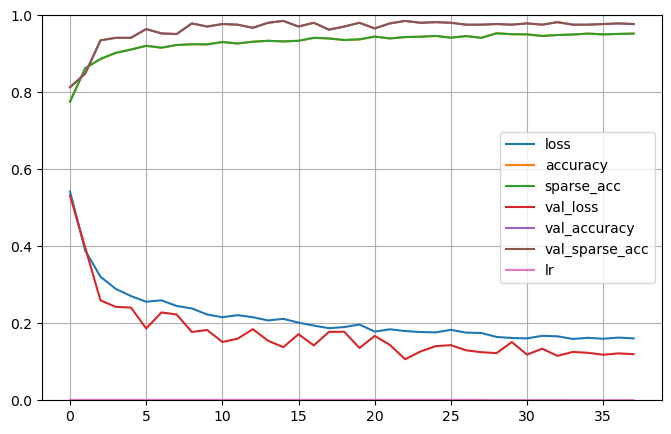

In [ ]:
pd.DataFrame(trained_nn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [ ]:
threshold = 0.82

y_pred_proba_raw = model.predict(test_features)  

if len(y_pred_proba_raw.shape) > 1 and y_pred_proba_raw.shape[1] == 2:
    print(f"\nModelo con softmax de 2 clases detectado. Usando probabilidad de clase 1 (Signal).")
    y_pred_proba = y_pred_proba_raw[:, 1]  # Probabilidad de la clase 1 (Signal)
else:
    raise ValueError("Formato inesperado de las predicciones del modelo.")

y_pred = (y_pred_proba > threshold).astype(int)


14/14 [==============================] - 0s 810us/step

Modelo con softmax de 2 clases detectado. Usando probabilidad de clase 1 (Signal).


In [ ]:
loss = results_on_test[0]
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy_score(test_labels, y_pred):.4f}")


Loss: 0.1886
Accuracy: 0.9487


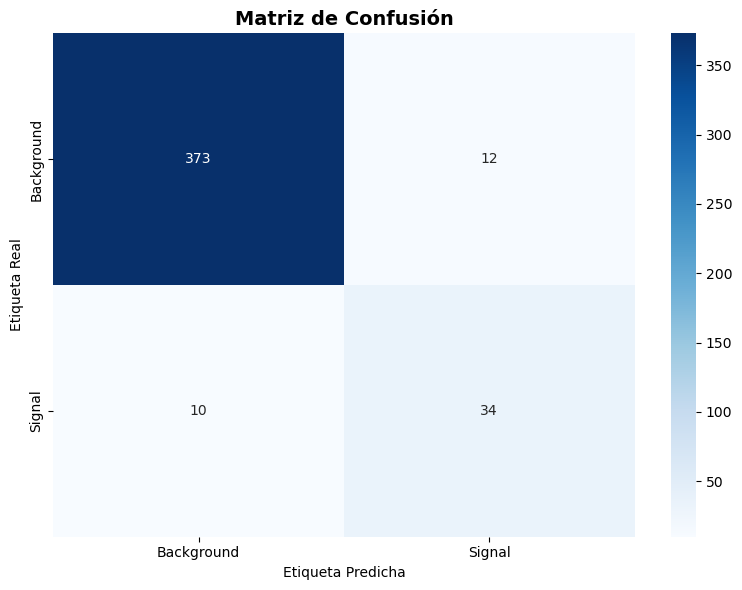


Reporte de Clasificación:
              precision    recall  f1-score   support

  Background       0.97      0.97      0.97       385
      Signal       0.74      0.77      0.76        44

    accuracy                           0.95       429
   macro avg       0.86      0.87      0.86       429
weighted avg       0.95      0.95      0.95       429



In [ ]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Background', 'Signal'],
            yticklabels=['Background', 'Signal'])
plt.title('Matriz de Confusión', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Métricas detalladas
print("\nReporte de Clasificación:")
print("="*50)
print(classification_report(test_labels, y_pred, 
                          target_names=['Background', 'Signal']))

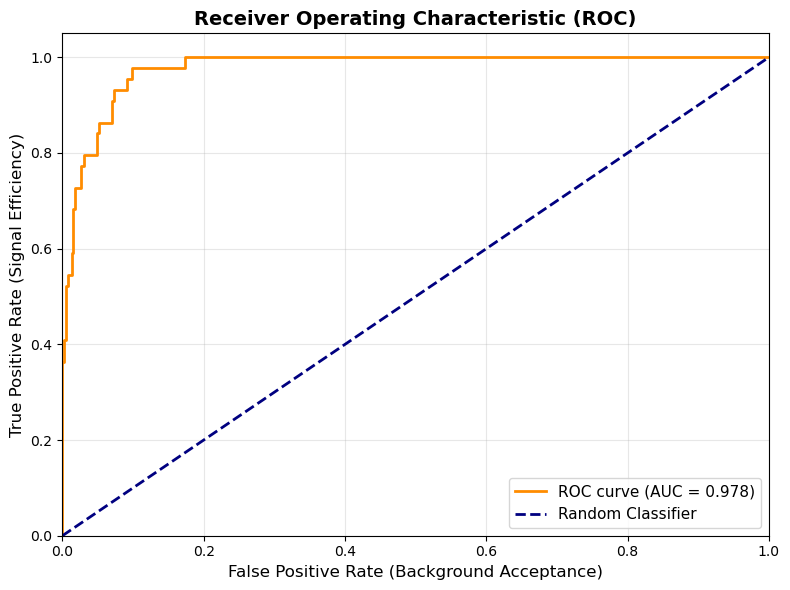

In [ ]:
fpr, tpr, thresholds_roc = roc_curve(test_labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Background Acceptance)', fontsize=12)
plt.ylabel('True Positive Rate (Signal Efficiency)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

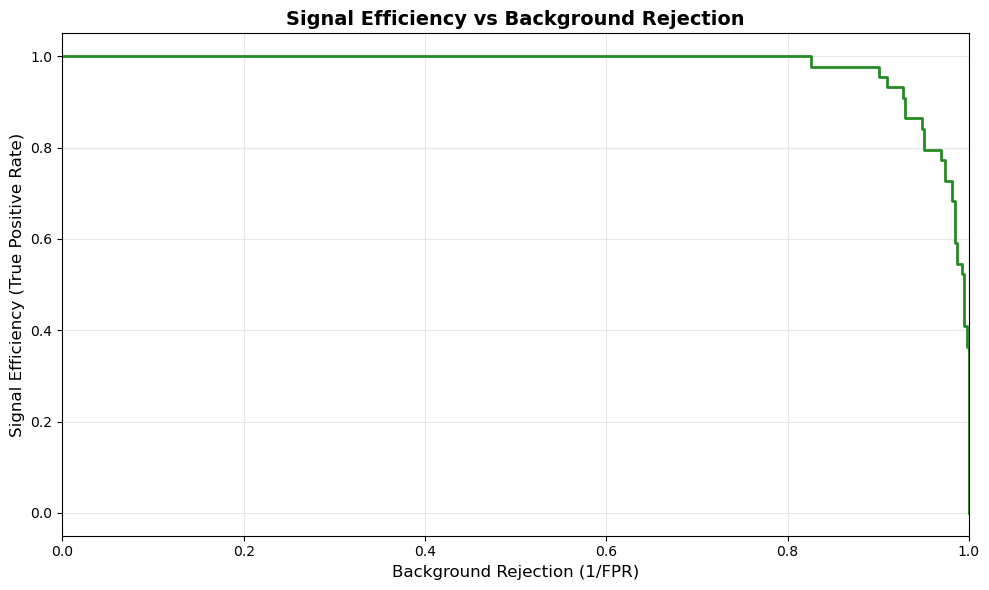

In [ ]:
fpr_nonzero = np.maximum(fpr, 1e-10)
background_rejection = 1.0 - fpr_nonzero

plt.figure(figsize=(10, 6))
plt.plot(background_rejection, tpr, color='forestgreen', lw=2)
plt.ylabel('Signal Efficiency (True Positive Rate)', fontsize=12)
plt.xlabel('Background Rejection (1/FPR)', fontsize=12)
plt.title('Signal Efficiency vs Background Rejection', fontsize=14, fontweight='bold')
# plt.yscale('log')  # Comentado para escala lineal
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.tight_layout()
plt.savefig('efficiency_vs_rejection.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([0,1, 0, 1])                   # Not shown


Text(0.5, 1.0, 'Precision-Recall vs Threshold (AUC = 0.850)')

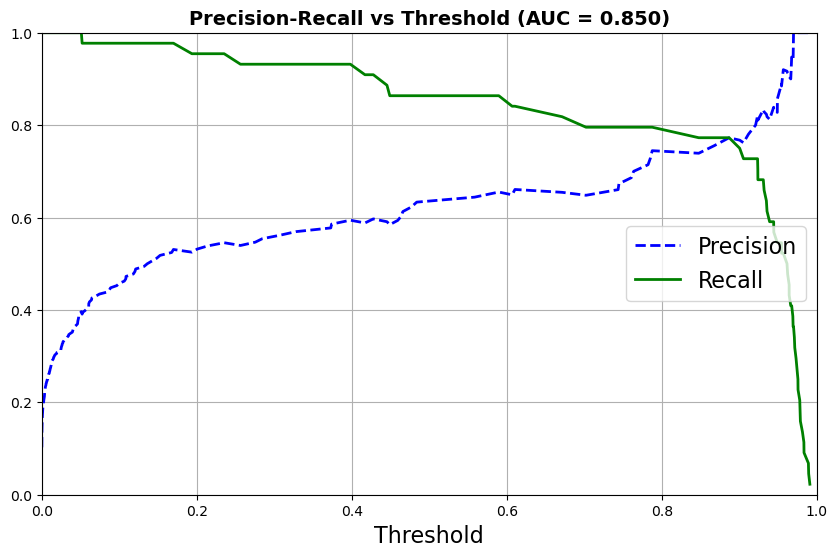

In [ ]:
precision, recall, thresholds_pr = precision_recall_curve(test_labels, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precision, recall, thresholds_pr)
plt.title(f'Precision-Recall vs Threshold (AUC = {pr_auc:.3f})', fontsize=14, fontweight='bold')


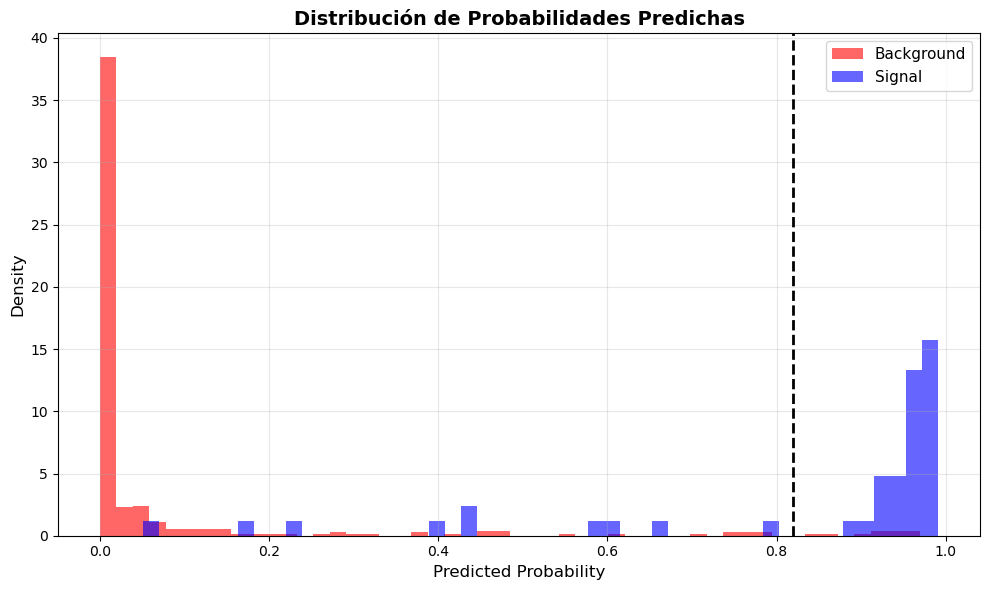

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[test_labels == 0], bins=50, alpha=0.6, 
         label='Background', color='red', density=True)
plt.hist(y_pred_proba[test_labels == 1], bins=50, alpha=0.6, 
         label='Signal', color='blue', density=True)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribución de Probabilidades Predichas', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
graphs = []
graphs_bg = []

for event_id in tqdm(signal['event'].unique()):
    event_df = signal[signal['event'] == event_id]
    hits = [BHit(x=row.X, y=row.Y, z=row.Z, E=row.Ec) for _, row in event_df.iterrows()]

    # Voxelizar hits del evento
    signal_voxels = voxelize_hits(hits, voxel_dimensions=(16.0, 16.0, 16.0))

    # Construir grafo con los voxeles completos del evento
    graph = make_track_graphs(signal_voxels)
    graphs.append(max(graph, key=lambda g: g.number_of_nodes()))

for event_id in tqdm(bkg['event'].unique()):
    event_df = bkg[bkg['event'] == event_id]
    hits = [BHit(x=row.X, y=row.Y, z=row.Z, E=row.Ec) for _, row in event_df.iterrows()]

    # Voxelizar hits del evento
    background_voxels = voxelize_hits(hits, voxel_dimensions=(16.0, 16.0, 16.0))

    # Construir grafo con los voxeles completos del evento
    graph_bg = make_track_graphs(background_voxels)
    graphs_bg.append(max(graph_bg, key=lambda g: g.number_of_nodes()))

 21%|██████████████████████████████████▉                                                                                                                                 | 410/1922 [11:14<41:11,  1.63s/it]

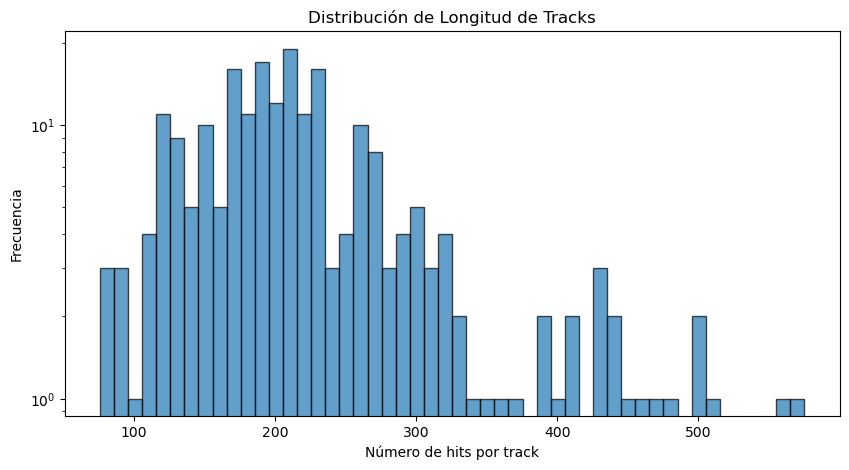

Tracks de 1 hit: 0
Tracks de 2+ hits: 222
Longitud media: 225.62


In [ ]:
def analyze_track_lengths(graphs):
    """Analiza las longitudes de los tracks."""
    track_lengths = []
    
    for i, graph in enumerate(graphs):
        
        n_hits = graph.number_of_nodes()
        track_lengths.append(n_hits)        

    plt.figure(figsize=(10, 5))
    plt.hist(track_lengths, bins=50, 
            edgecolor='black', alpha=0.7)
    plt.xlabel('Número de hits por track')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Longitud de Tracks')
    plt.yscale('log')
    plt.show()
    
    print(f"Tracks de 1 hit: {track_lengths.count(1)}")
    print(f"Tracks de 2+ hits: {sum(1 for l in track_lengths if l > 1)}")
    print(f"Longitud media: {np.mean(track_lengths):.2f}")
    
    return track_lengths

track_lengths = analyze_track_lengths(graphs)

In [ ]:
results = []
blob_energy_signals = []
blob_energy_backgrs = []

for track in tqdm(graphs):
    a = blob_energies_hits_and_centres(track, radius = 100.0)
    blob_energy_signals.append(a[0:2])
    results.append(a)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [04:05<00:00,  1.11s/it]


In [ ]:
blob_energy_signals = np.array(blob_energy_signals)

In [ ]:
ratios = []
for r in blob_energy_signals:
    ratios.append(r[0] / r[1])

(array([67., 41., 30., 16.,  8., 10.,  4.,  5.,  6.,  4.,  2.,  3.,  3.,
         5.,  2.,  2.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,
         0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 1.00145761,  1.27203018,  1.54260274,  1.81317531,  2.08374787,
         2.35432044,  2.624893  ,  2.89546557,  3.16603813,  3.4366107 ,
         3.70718326,  3.97775583,  4.24832839,  4.51890096,  4.78947352,
         5.06004609,  5.33061865,  5.60119122,  5.87176378,  6.14233635,
         6.41290891,  6.68348148,  6.95405404,  7.22462661,  7.49519917,
         7.76577173,  8.0363443 ,  8.30691686,  8.57748943,  8.84806199,
         9.11863456,  9.38920712,  9.65977969,  9.93035225, 10.20092482,
        10.47149738, 10.74206995, 11.01264251, 11.28321508, 11.55378764,
        11.82436021, 12.09493277, 12.36550534, 12.6360779 , 12.90665047,
        13.17722303, 13.4477956 , 13.71836816, 13.98894073,

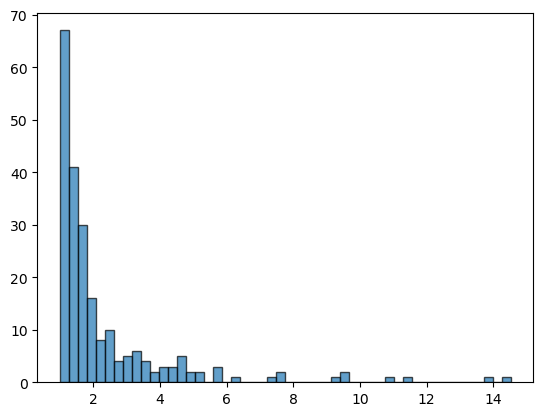

In [ ]:
plt.hist(ratios, bins=50, edgecolor='black', alpha=0.7)